# Homework #3 -- *you'll need to do this on google colab*

0. Find data set on [kaggle](https://www.kaggle.com).
1. Provide posterior inference for a column of data with a `PyMC` ***normal-gamma specification***.
2. Find a different column of data for which a ***normal-gamma specification*** isn't justified.
3. Create a different `PyMC` specification that IS appropriate for this new data column:
    - here are your `PyMC` choices for [continuous distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/continuous.html)
    - here are your `PyMC` choices for [discrete distributions](https://www.pymc.io/projects/docs/en/stable/api/distributions/discrete.html)

### ...just make sure you've chosen a reasonable likelihood for your non-normal data and that the support of your priors makes sense for the values the parameters of your likelihood can take on...

4. Provide posterior inference for the parameters of your new specification given the column of non-normal data
using `PyMC` and provide an analysis of the MCMC chains.

# Solution by Mohammad Yassin

The dataset Im using for my work is The Heart Disease Prediction Dataset.

It encompasses information about patients, their medical history, and several key clinical factors. These factors include age, gender, chest pain type, blood pressure, cholesterol levels, and much more. The dataset is particularly noteworthy for its diversity, combining data from multiple sources and aggregating it into a single, extensive dataset, which will be useful for finding both normal and non normally distributed variables.

This is the link to the dataset: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [6]:
import numpy as np
from scipy import stats
import pandas as pd
import requests
import random
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import seaborn as sns

# Read dataset
heart_data = pd.read_csv("heart.csv")

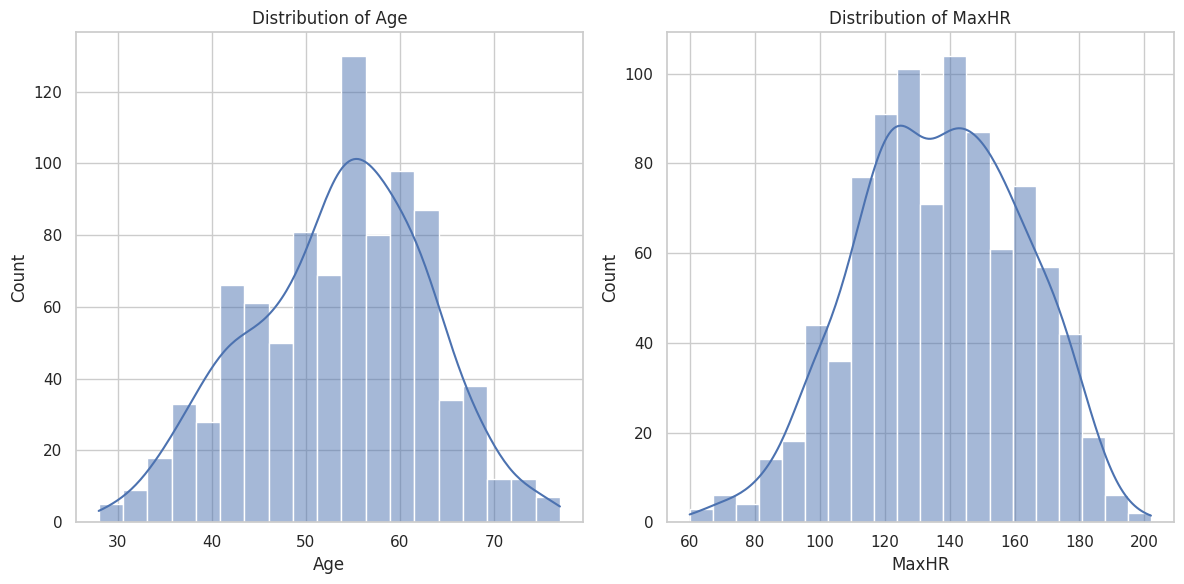

In [35]:
#Plotting the normal and non normally distributed columns

sns.set(style="whitegrid")

# Plot for 'Age'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(heart_data['Age'], kde=True)
plt.title('Distribution of Age')

# Plot for 'MaxHR'
plt.subplot(1, 2, 2)
sns.histplot(heart_data['MaxHR'], kde=True)
plt.title('Distribution of MaxHR')

plt.tight_layout()
plt.show()

The left plot displays the distribution of the maximum heart rate achieved by patients. Age is a continuous variable, and as we can observe, it follows a relatively normal distribution with some variation.

The right plot displays the distribution of ages within the dataset. MaxHR follows a more skewed distribution and is not normally distributed.

In [66]:
#Part 1
age_data = heart_data['Age'].values

normal_gamma_toy_model = pm.Model()
with normal_gamma_toy_model:
    theta = pm.Normal("theta", mu=0, sigma=1)
    phi = pm.Gamma("phi", alpha=1, beta=1)
    x_obs = pm.Normal("likelihood", mu=theta, sigma=1/phi**0.5, observed=age_data)
    idata_HMC = pm.sample(random_seed=42)

I initialize the normal_gamma model, specify priors for θ and ϕ, and define the likelihood of observing the age data. I invoke HMC sampling with a random seed to ensure reproducibility.



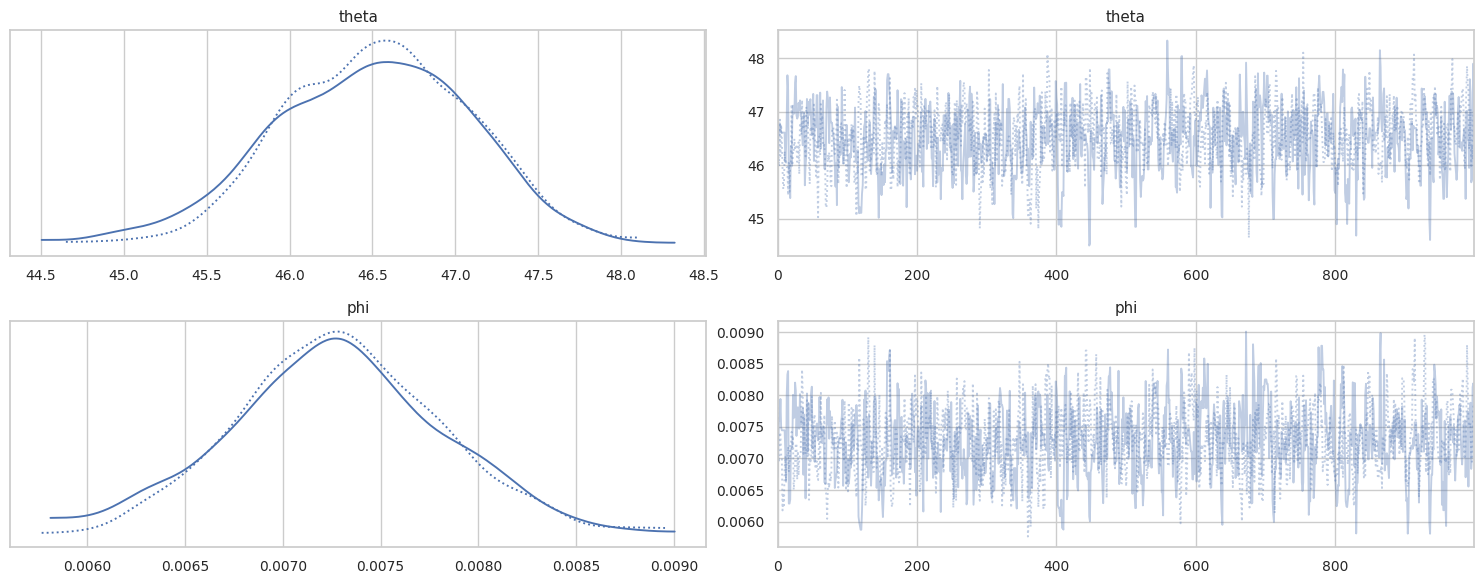

In [67]:
fig, ax = plt.subplots(2, 2, figsize=(15, 6))

az.plot_trace(idata_HMC, axes=ax[:, :2])

plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.tight_layout()

plt.show()

In [68]:
#Part 2, 3 and 4
max_hr_data = heart_data['MaxHR'].values
max_hr_stats = heart_data['MaxHR'].describe()

# Using the Student's T-distribution for the 'MaxHR' data
with pm.Model() as model:
    # Priors for the Student's T-distribution parameters
    mu = pm.Normal('mu', mu=max_hr_stats['mean'], sigma=max_hr_stats['std'])
    sigma = pm.HalfNormal('sigma', sigma=max_hr_stats['std'])
    nu = pm.Exponential('nu', 1/29)

    # Likelihood of observed data
    max_hr_obs = pm.StudentT('max_hr_obs', nu=nu, mu=mu, sigma=sigma, observed=max_hr_data)

    # Inference
    idata_HMC = pm.sample(random_seed=42)


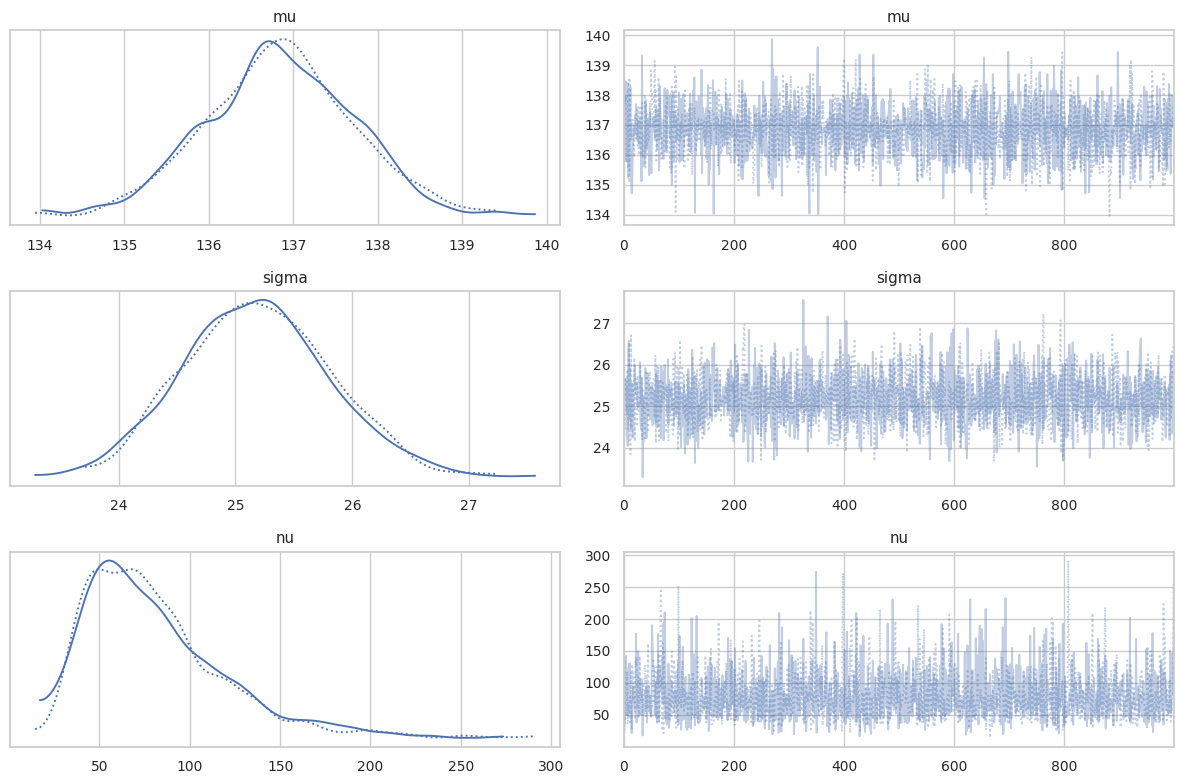

number of MCMC samples: 2000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,136.84,0.88,135.28,138.55,0.02,0.01,2359.77,1605.44,1.0
sigma,25.19,0.62,24.07,26.31,0.01,0.01,2642.44,1212.07,1.0
nu,80.37,38.92,19.68,150.50,0.80,0.61,2394.86,1523.19,1.0


In [74]:
# Visualization
fig, ax = plt.subplots(3, 2, figsize=(12, 8))  # Adjust for the number of parameters

az.plot_trace(idata_HMC, var_names=['mu', 'sigma', 'nu'], axes=ax)

plt.tight_layout()

plt.show()

print("number of MCMC samples:", idata_HMC.posterior['mu'].values.flatten().shape[-1])
az.summary(idata_HMC, round_to=2)

The marginal posterior for mu (the mean of the MaxHR) appears to be normally distributed, centered around 136-137, which is consistent with the sample mean. This suggests that the mean of the MaxHR is fairly well estimated by the model.

The marginal posterior for sigma (the scale or spread of MaxHR) indicates a peak around 24-25, suggesting a moderate level of uncertainty around the estimate of the spread of MaxHR values.

The marginal posterior for nu (degrees of freedom of the t-distribution) has a peak around 50-100 and a long right tail, indicating some uncertainty about the heaviness of the tails in the distribution of MaxHR.

There do not appear to be strong trends or cycles in the trace plots, which is positive for convergence. This is bolstered by the r_hat for all three parameters being 1, suggestign that the chains have converged to the stationary distribution.

